In [2]:
import pandas as pd
from sklearn.datasets import load_iris
# Load the iris dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns =iris.feature_names)
df["target"] = iris.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


X_train,X_test,y_train,y_test = train_test_split(
    df[iris.feature_names],df['target'],test_size=0.3,
stratify = df['target'],random_state=42)


results = []

for depth in range(1,6):
    clf = DecisionTreeClassifier(
        max_depth = depth,
        min_samples_split = 5,
        min_samples_leaf = 2,
        random_state = 42
    )
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')

    results.append({
        'max_depth':depth,
        'precision':precision,
        'recall':recall,
        'f1_score':f1
    })

results_df = pd.DataFrame(results)
results_df


e:\ANACONDA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,max_depth,precision,recall,f1_score
0,1,0.500000,0.666667,0.555556
1,2,0.889881,0.888889,0.888765
2,3,0.934524,0.933333,0.933259
3,4,0.898148,0.888889,0.887767
4,5,0.898148,0.888889,0.887767


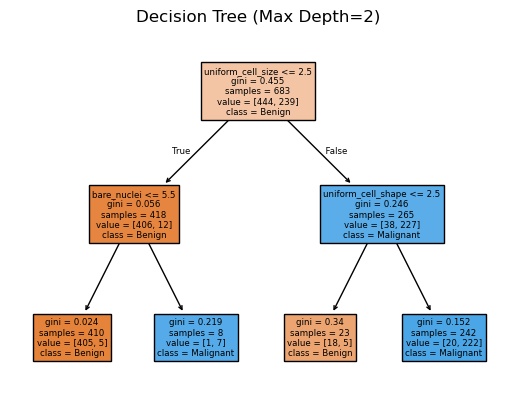

Feature selected for the first split: uniform_cell_size
Split threshold: 2.5000
Root Node Class Distribution (Benign, Malignant): [0.65007321 0.34992679]
Root Node Entropy: 0.9340
Root Node Gini: 0.4550
Root Node Misclassification Error: 0.3499
----------------------------------------
Left Child Node Class Distribution (Benign, Malignant): [0.97129187 0.02870813]
Left Child Node Entropy: 0.1879
Left Child Node Gini: 0.0558
Left Child Node Misclassification Error: 0.0287
----------------------------------------
Right Child Node Class Distribution (Benign, Malignant): [0.14339623 0.85660377]
Right Child Node Entropy: 0.5931
Right Child Node Gini: 0.2457
Right Child Node Misclassification Error: 0.1434
----------------------------------------
Information Gain (based on Entropy): 0.1531


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import math


def calc_entropy(distribution):
    total = sum(distribution)
    return -sum((cnt / total) * math.log2(cnt / total) for cnt in distribution if cnt != 0)

def calc_gini(distribution):
    total = sum(distribution)
    return 1 - sum((cnt / total) ** 2 for cnt in distribution)

def calc_misclassification_error(distribution):
    total = sum(distribution)
    return 1 - max(cnt / total for cnt in distribution)

def print_metrics(node_name, distribution):
    print(f"{node_name} Class Distribution (Benign, Malignant): {distribution}")
    print(f"{node_name} Entropy: {calc_entropy(distribution):.4f}")
    print(f"{node_name} Gini: {calc_gini(distribution):.4f}")
    print(f"{node_name} Misclassification Error: {calc_misclassification_error(distribution):.4f}")
    print("-" * 40)

column_names = [
    'id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
    'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei',
    'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'
]

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(url, names=column_names)

df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df['bare_nuclei'] = df['bare_nuclei'].astype(int)

X = df.drop(['id', 'class'], axis=1)
y = df['class'].map({2: 0, 4: 1})  # Benign=0, Malignant=1


clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=0
)
clf.fit(X, y)

plot_tree(clf, feature_names=X.columns, class_names=["Benign", "Malignant"], filled=True)
plt.title("Decision Tree (Max Depth=2)")
plt.show()


root_dist = clf.tree_.value[0][0]
left_node = clf.tree_.children_left[0]
right_node = clf.tree_.children_right[0]

left_dist = clf.tree_.value[left_node][0]
right_dist = clf.tree_.value[right_node][0]

feature_idx = clf.tree_.feature[0]
threshold = clf.tree_.threshold[0]
feature_name = X.columns[feature_idx]

print(f"Feature selected for the first split: {feature_name}")
print(f"Split threshold: {threshold:.4f}")
print("=" * 40)


print_metrics("Root Node", root_dist)
print_metrics("Left Child Node", left_dist)
print_metrics("Right Child Node", right_dist)


root_entropy = calc_entropy(root_dist)
left_entropy = calc_entropy(left_dist)
right_entropy = calc_entropy(right_dist)

total_samples = sum(root_dist)
left_weight = sum(left_dist) / total_samples
right_weight = sum(right_dist) / total_samples

weighted_entropy = left_weight * left_entropy + right_weight * right_entropy
info_gain = root_entropy - weighted_entropy

print(f"Information Gain (based on Entropy): {info_gain:.4f}")


In [17]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. 加载数据
# ==========================================
# UCI 乳腺癌诊断型数据（连续版本）
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

# 列名
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df = pd.read_csv(url, header=None, names=columns)

# 标签编码（M=恶性=1，B=良性=0）
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# 特征和标签
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=0, stratify=y
)

# ==========================================
# 2. PCA 降维
# ==========================================
pca_1 = PCA(n_components=1)
pca_2 = PCA(n_components=2)

X_train_pca1 = pca_1.fit_transform(X_train)
X_test_pca1 = pca_1.transform(X_test)

X_train_pca2 = pca_2.fit_transform(X_train)
X_test_pca2 = pca_2.transform(X_test)

# ==========================================
# 3. 决策树模型训练
# ==========================================
def train_and_evaluate(X_tr, X_te, y_tr, y_te, description=""):
    clf = DecisionTreeClassifier(
        criterion='gini',
        max_depth=2,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=0
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)

    # 计算评估指标
    f1 = f1_score(y_te, y_pred)
    precision = precision_score(y_te, y_pred)
    recall = recall_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)

    tn, fp, fn, tp = cm.ravel()

    # 假阳性率 (FPR), 真阳性率 (TPR)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"==== {description} ====")
    print(f"F1 Score        : {f1:.4f}")
    print(f"Precision       : {precision:.4f}")
    print(f"Recall          : {recall:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"False Positives (FP): {fp}")
    print(f"True Positives (TP): {tp}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"True Positive Rate (TPR): {tpr:.4f}")
    print("=" * 40 + "\n")

# ==========================================
# 4. 训练与评估
# ==========================================
# 1个主成分
train_and_evaluate(X_train_pca1, X_test_pca1, y_train, y_test, description="PCA - 1 Principal Component")

# 2个主成分
train_and_evaluate(X_train_pca2, X_test_pca2, y_train, y_test, description="PCA - 2 Principal Components")

# 原始数据（连续特征，未降维）
train_and_evaluate(X_train, X_test, y_train, y_test, description="Original Continuous Data")


==== PCA - 1 Principal Component ====
F1 Score        : 0.8194
Precision       : 0.7375
Recall          : 0.9219
Confusion Matrix:
[[86 21]
 [ 5 59]]
False Positives (FP): 21
True Positives (TP): 59
False Positive Rate (FPR): 0.1963
True Positive Rate (TPR): 0.9219

==== PCA - 2 Principal Components ====
F1 Score        : 0.8201
Precision       : 0.7600
Recall          : 0.8906
Confusion Matrix:
[[89 18]
 [ 7 57]]
False Positives (FP): 18
True Positives (TP): 57
False Positive Rate (FPR): 0.1682
True Positive Rate (TPR): 0.8906

==== Original Continuous Data ====
F1 Score        : 0.8392
Precision       : 0.7595
Recall          : 0.9375
Confusion Matrix:
[[88 19]
 [ 4 60]]
False Positives (FP): 19
True Positives (TP): 60
False Positive Rate (FPR): 0.1776
True Positive Rate (TPR): 0.9375

